In [27]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 256                   # output image dimension (must be power of 2)
psf_pixelscale_lamD = 0.1    # output sampling in lam0/D
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD

# define the offsets in lambda/D for which the PSFs will be created
start = 0
stop = 11
step = 0.05
offsets_lamD = np.arange(start,stop+step,step)
offsets_mas = offsets_lamD*mas_per_lamD
print(offsets_mas[-1])

polaxis = 1

552.0819683944327 mas


# Setup the interpolation function

In [28]:
# next use the  the non DM proper psfs
psfs_fpath = Path('C:/Users/Kian/Documents/data-files/disk-processing/psfs/hlc_phasec_polaxis1.fits')
psfs = fits.getdata(psfs_fpath)
psfs = np.moveaxis(psfs,0,-1)

# setup the interpolating functions
x = range(npsf)
y = range(npsf)
z = offsets_mas
interpfun = RegularGridInterpolator((x, y, z), psfs, method='nearest', bounds_error=False, fill_value=0)

# Test the interpolating function

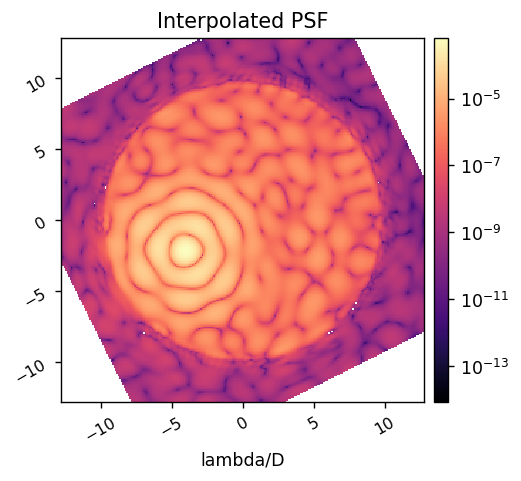

In [29]:
def find_closest_psf(xoff, yoff, interpfun, n):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)

    grid = np.meshgrid(range(n),range(n))
    flattened_grid = np.vstack([grid[0].flatten(),grid[1].flatten()])
    pts = np.vstack([ flattened_grid, r.value*np.ones(len(grid[0].flatten())) ]).T

    interpped = interpfun(pts).reshape(n,n).T
    interpped = rotate(interpped,-theta.value, reshape=False, order=3)
    return interpped

n = npsf
xoff = -200*u.milliarcsecond
yoff = -100*u.milliarcsecond
interpped_psf = find_closest_psf(xoff, yoff, interpfun, n)
misc.myimshow(interpped_psf, 'Interpolated PSF', pxscl=psf_pixelscale_lamD, lognorm=True)

# Create the grid for which the interpolated PSFs will be calculated

In [39]:
ndisk = 100
disk_pixelscale_mas = 20.8*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2),np.arange(-ndisk/2,ndisk/2)) # 256by256 grid
x = (x+1/2).flatten()*disk_pixelscale_mas
y = (y+1/2).flatten()*disk_pixelscale_mas

In [40]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], interpfun, npsf)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    clear_output()
    print(i, time.time()-start)

9999 122.21786761283875


In [41]:
ipsf_fpath = Path('C:/Users/Kian/Documents/data-files/disk-processing/ipsfs/ipsf_matrix_polaxis{:d}.hdf5'.format(polaxis))
f = h5py.File(ipsf_fpath,'w')
ipsf_matrix = f.create_dataset('IPSF Matrix', data=ipsf_matrix)
f.close()